# Attempt 1 - Logistic Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import chi2_contingency

from src.data.transforms.simple_transform import (
    drop_correlated_vars_impute_transform, log_balance_vars_transform, log_almost_all_vars_transform,
    log_almost_all_vars_transform_v2, log_almost_all_vars_transform_v3)
from src.data.utils import read_df, get_xy
from src.nb_utils.data import summarize_df, plot_df
from src.nb_utils.eval import plot_roc, plot_pr, model_binning_summary
from src.data.transforms.woe_transform import forced_binning, WoETransform
from src.models.fit import kfold_fit, df_train_test_stratify_split, fit_and_eval
from src.models.ensemble import Ensemble 
from src.models.models import StatsModelsLogisticRegression
from src.utils.eval import generate_test_output

# Read Data

In [2]:
raw_df = read_df("./data/dataset/cs-training.csv")

## Check for missing values
MonthlyIncome is a concern for missing data as it represents close to 20% of training data. May have to handle this later (either by assigning zero or its own 'N/A' class if we choose to do binning)

NumberOfDependents missing data is miniscule - we may choose to drop them from training or impute zeros (must check test data to see if we need to handle it as 0 or not)

In [3]:
total_rows = len(raw_df)

# Get N/A counts
na_counts = raw_df.isna().sum()
na_counts.name = "N/A count"

# Get N/A ratio
na_ratio = na_counts / total_rows
na_ratio.name = "N/A fraction"

# Combine counts & ratio into a summary table
na_df = pd.concat([na_counts, na_ratio], axis=1)
na_df.index.name = 'Variable Name'
na_df = na_df.sort_values(by=['N/A count'], ascending=False, kind='heapsort')

na_df

,N/A count,N/A fraction
Variable Name,,
MonthlyIncome,29731,0.198207
NumberOfDependents,3924,0.026160
SeriousDlqin2yrs,0,0.000000
RevolvingUtilizationOfUnsecuredLines,0,0.000000
age,0,0.000000
NumberOfTime30-59DaysPastDueNotWorse,0,0.000000
DebtRatio,0,0.000000
NumberRealEstateLoansOrLines,0,0.000000
NumberOfOpenCreditLinesAndLoans,0,0.000000


Check whether rows with missing data have disproportionate class representation. Seems like in all cases the minority class is underrepresented so it may not be a huge issue even if we choose to drop such (except for MonthlyIncome which makes up to 20% of the portfolio)

In [4]:
# Pandas crude analog to 'select SeriousDlqin2yrs, count(*) from table group by SeriousDlqin2yrs'
na_pos = raw_df[raw_df['NumberOfTime60-89DaysPastDueNotWorse'] == 1].isna().sum()
na_neg = raw_df[raw_df['NumberOfTime60-89DaysPastDueNotWorse'] == 0].isna().sum()

na_pos.name = "N/A count (SeriousDlqin2yrs=1)"
na_neg.name = "N/A count (SeriousDlqin2yrs=0)"

na_all = na_pos + na_neg
na_pos_perc = na_pos / na_all
na_neg_perc = na_neg / na_all

na_pos_perc.name = "N/A ratio (SeriousDlqin2yrs=1)"
na_neg_perc.name = "N/A ratio (SeriousDlqin2yrs=0)"

na_pn_df = pd.concat([na_pos, na_neg, na_pos_perc, na_neg_perc], axis=1)
na_pn_df.index.name = 'Variable Name'

na_pn_df

,N/A count (SeriousDlqin2yrs=1),N/A count (SeriousDlqin2yrs=0),N/A ratio (SeriousDlqin2yrs=1),N/A ratio (SeriousDlqin2yrs=0)
Variable Name,,,,
id,0,0,NaN,NaN
SeriousDlqin2yrs,0,0,NaN,NaN
RevolvingUtilizationOfUnsecuredLines,0,0,NaN,NaN
age,0,0,NaN,NaN
NumberOfTime30-59DaysPastDueNotWorse,0,0,NaN,NaN
DebtRatio,0,0,NaN,NaN
MonthlyIncome,924,28402,0.031508,0.968492
NumberOfOpenCreditLinesAndLoans,0,0,NaN,NaN
NumberOfTimes90DaysLate,0,0,NaN,NaN


## Check class dist
Baseline portfolio has 6.68% delinquency - prediction is for minority class=1

In [5]:
val_counts = raw_df["SeriousDlqin2yrs"].value_counts()
print(val_counts)

neg_count = val_counts[0]
pos_count = val_counts[1]
pos_ratio = pos_count / (pos_count + neg_count)

print(f"pos_ratio={100 * pos_ratio:.3f}%")

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64
pos_ratio=6.684%


Do a quick-and-dirfy Chi-Square Test for the var with missing value NumberOfDependents

In [6]:
ndep = raw_df['NumberOfDependents'].replace(np.nan, 'NA')
contingency = pd.crosstab(ndep, raw_df['SeriousDlqin2yrs'], normalize='index')
contingency

SeriousDlqin2yrs,0,1
NumberOfDependents,,
0.0,0.941371,0.058629
1.0,0.926471,0.073529
2.0,0.918861,0.081139
3.0,0.911737,0.088263
4.0,0.896226,0.103774
5.0,0.908847,0.091153
6.0,0.848101,0.151899
7.0,0.901961,0.098039
8.0,0.916667,0.083333


We see low dependence (p_value >> 0.05) w. r. t. default. However rather than dropping this variable now we'll include it, but we have more confidence that we can impute N/A as 0 as it has the closest 0/1 delinquency distribution w. r. t. that class, and because this variable alone is not a predictor of delinquency

In [7]:
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"p-value={p:.3f} for dof={dof}")

p-value=1.000 for dof=13


# Plot Histograms of Attributes
We see a lot of skewness - for some float variables e.g. DebtRatio, MonthlyIncome, RevolvingUtilization, we can try taking the log (hand-waving assumption that these skewness could be lognormal - regardless it is just a way to spread them out quickly without resorting to manual descritizataion and binning) 

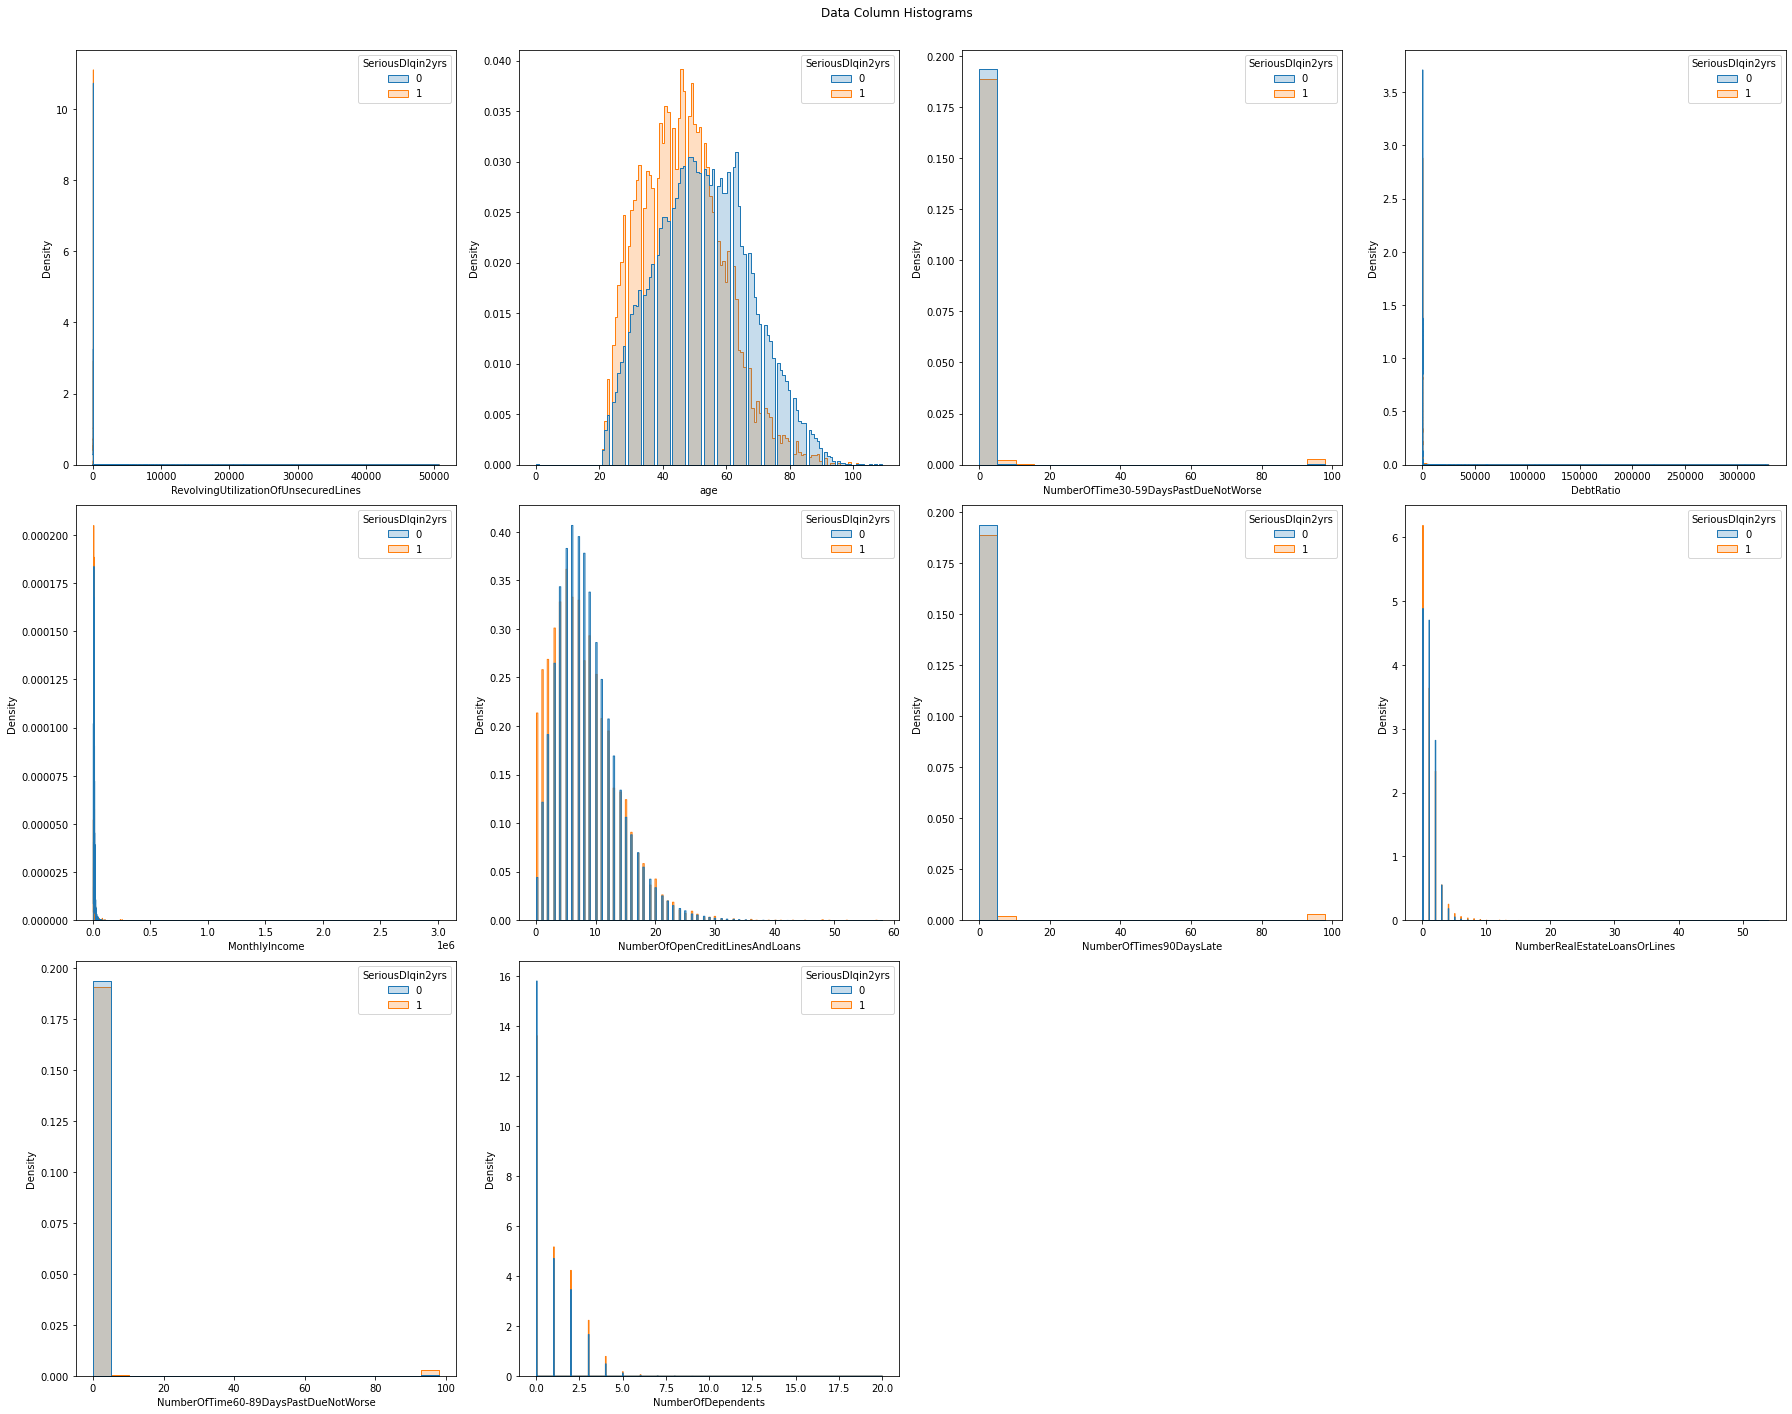

In [8]:
plot_df(raw_df)

# Simple Pearson Correlation Analysis
We find 3 pairs of highly-correalted variables - they shouldn't affect model's predictive power but we will lose coefficient explainability in regression type models - so, we will remove them (fn drop_correlated_vars_impute_transform). We will keep NumberOfTime30-59DaysPastDueNotWorse as the other 2 cols' distributions are very bunched up at 0 (84% for the one we're keeping, ~94% for the other 2))

Note - if we follow till the end we'll see that this is probably not the right move, as it turns out including all 3 late & past due columns improves model performance. These 3 correlated variables appear to be linked, possibly because e.g. someone who's 90 days late will also be 30-59 days and 69-89 days late. However due to time constraint we'll not be exploring it, and later on we'll just choose the model that doesn't engineer or drop this feature as the final

var1                                       var2                                     corr
NumberOfTimes90DaysLate                  - NumberOfTime60-89DaysPastDueNotWorse     0.9928
NumberOfTime30-59DaysPastDueNotWorse     - NumberOfTime60-89DaysPastDueNotWorse     0.9870
NumberOfTime30-59DaysPastDueNotWorse     - NumberOfTimes90DaysLate                  0.9836


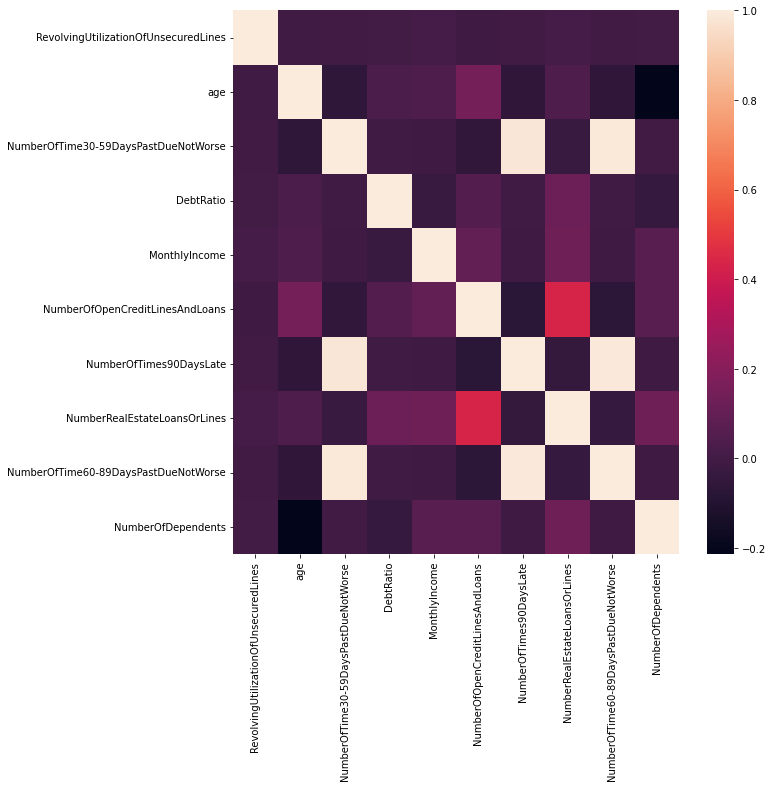

In [9]:
analysis_df = raw_df.drop(columns=['id', 'SeriousDlqin2yrs'])

var_correlations = analysis_df.corr()

plt.figure(figsize=(10, 10))
ax = sns.heatmap(var_correlations)

nvars = var_correlations.shape[0]
var_names = var_correlations.index.values

corrs = []
for ivar in range(nvars):
    for jvar in range(ivar + 1, nvars):
        icorr = var_correlations.iloc[ivar, jvar]
        corrs.append((var_names[ivar], var_names[jvar], icorr))
        
corrs.sort(key=lambda x: x[-1], reverse=True)
print(f"{'var1':40s}   {'var2':40s} {'corr':4s}")
for ivar, jvar, ijcorr in corrs:
    if abs(ijcorr) > 0.5:
        print(f"{ivar:40s} - {jvar:40s} {ijcorr:.4f}")

# Plot logged transform
We can also see visually that some variables are already predictive based on the distribution between the 0 and 1 classes e.g. age, Past due, open credit lines

In the cell below (in all cases, imputation is done as discussed above)
1. df_drop = Drop 2 of the 3 correlated past due/90 days late variable (see fn drop_correlated_vars_impute_transform())
2. df_log_some = log(x) of balance-related variables only (see fn log_balance_vars_transform() for which ones)
3. df_lost_most = log(x) of almost all the vars (see fn log_almost_all_vars_transform() for which ones)
4. df_log_most_v2 = Similar to #3, but don't drop any of the correalted vars
5. df_log_most_v3 = Similar to #4, but the 3 past due and 90 days late vars are condensed into a single max()

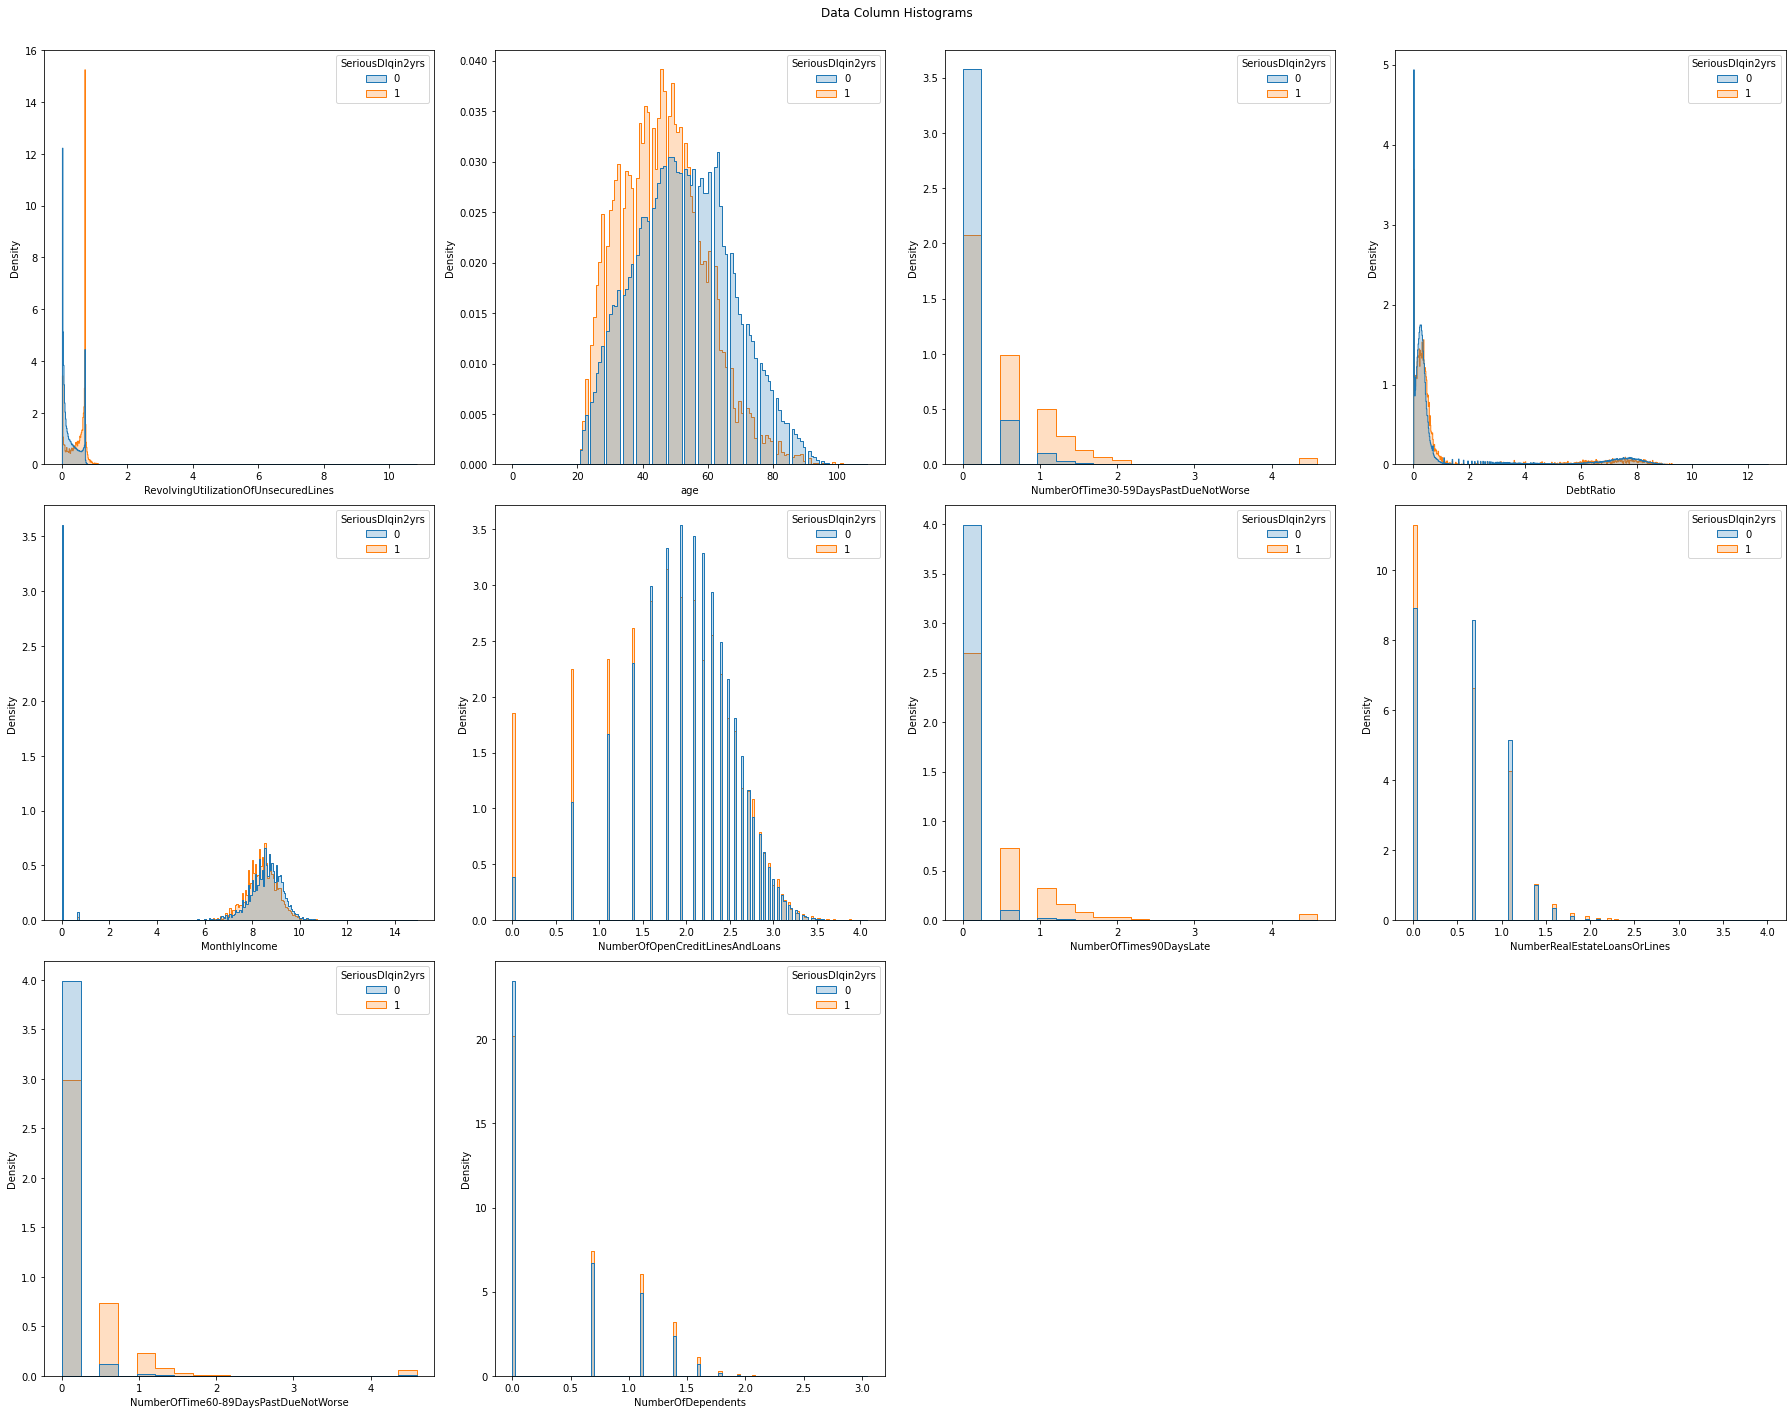

In [10]:
df_drop, _ = drop_correlated_vars_impute_transform(raw_df)
df_log_some, _ = log_balance_vars_transform(raw_df)
df_log_most, _ = log_almost_all_vars_transform(raw_df)
df_log_most_v2, _ = log_almost_all_vars_transform_v2(raw_df)
df_log_most_v3, _ = log_almost_all_vars_transform_v3(raw_df)

plot_df(df_log_most_v2)

# Fit Models
Try 3 different transforms in 80-20 5-fold cross validation with AUC as validator

In [11]:
print(f"Test 1 - drop columns only")
sm_model_1 = kfold_fit(df_drop, 5, StatsModelsLogisticRegression)

Test 1 - drop columns only
kfold x-val for k=5
run 1 - class [0 1] for train=[111980   8020], test=[27994  2006] --> AUC=0.752
run 2 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.744
run 3 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.746
run 4 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.761
run 5 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.751


In [12]:
print(f"Test 2 - drop columns & log some")
sm_model_2 = kfold_fit(df_log_some, 5, StatsModelsLogisticRegression)

Test 2 - drop columns & log some
kfold x-val for k=5
run 1 - class [0 1] for train=[111980   8020], test=[27994  2006] --> AUC=0.821
run 2 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.816
run 3 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.827
run 4 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.805
run 5 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.828


In [13]:
print(f"Test 3 - drop columns & log most")
sm_model_3 = kfold_fit(df_log_most, 5, StatsModelsLogisticRegression)
sm_model_3.save("./data/models/sm_model_3.pckl")

Test 3 - drop columns & log most
kfold x-val for k=5
run 1 - class [0 1] for train=[111980   8020], test=[27994  2006] --> AUC=0.819
run 2 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.821
run 3 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.819
run 4 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.834
run 5 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.829


Also just try model without dropping any of the past due variables

In [14]:
print(f"Test 4 - don't drop columns & log most")
sm_model_4 = kfold_fit(df_log_most_v2, 5, StatsModelsLogisticRegression)
sm_model_4.save("./data/models/sm_model_4.pckl")

Test 4 - don't drop columns & log most
kfold x-val for k=5
run 1 - class [0 1] for train=[111980   8020], test=[27994  2006] --> AUC=0.857
run 2 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.852
run 3 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.851
run 4 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.856
run 5 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.856


Also try with max'ing the past dues and 90 days late column to reduce those 3 into a single column

In [15]:
print(f"Test 5 - combine past due and late columns & log most")
sm_model_5 = kfold_fit(df_log_most_v3, 5, StatsModelsLogisticRegression)
sm_model_5.save("./data/models/sm_model_5.pckl")

Test 5 - combine past due and late columns & log most
kfold x-val for k=5
run 1 - class [0 1] for train=[111980   8020], test=[27994  2006] --> AUC=0.853
run 2 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.848
run 3 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.851
run 4 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.849
run 5 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.849


# Pick "Test 3" & "Test 4" Models & Plot ROC/PR curves
We see that AUC is good (~0.8) but PR isn't - looks like the case where model has distinguishing power but because of severe class imbalance in the evaluated data we cannot have high precision with high recall

## Test 3

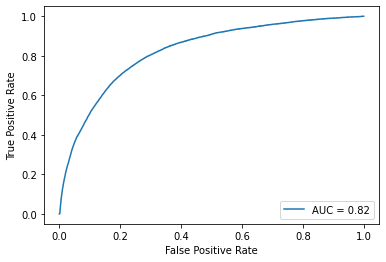

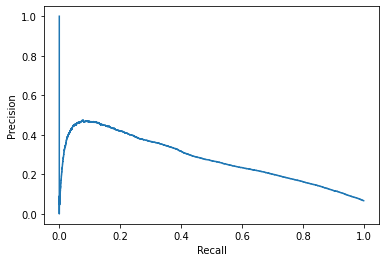

In [16]:
sm_model_3 = StatsModelsLogisticRegression("./data/models/sm_model_3.pckl")

X, y = get_xy(df_log_most)
plot_roc(sm_model_3, X, y)
plot_pr(sm_model_3, X, y)

## Test 4

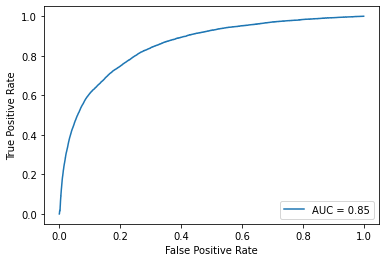

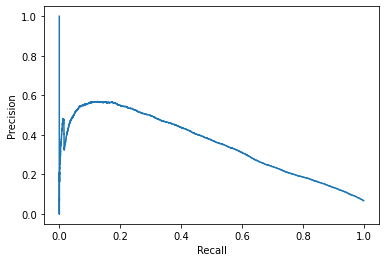

In [17]:
sm_model_4 = StatsModelsLogisticRegression("./data/models/sm_model_4.pckl")

X, y = get_xy(df_log_most_v2)
plot_roc(sm_model_4, X, y)
plot_pr(sm_model_4, X, y)

If we bin delinquent rate by bracket scores of the entire dataset we see that those with low prob of delinquency based on model will also have very low % delinquency in reality (0.8% for score 0-0.1 bracket i.e. 0-10%). However we see that even at the highest bracket (0.9-1.0) the % delinquency is only ~46%, not close to 100% as one would expect if the model has good PR curve. Depending on the use case, we can get away with using this model to limit exposure to bad customers who have high chance of default (e.g. choosing only to grant credit to customers with prob delinquency < 0.5), and the model's bad PR curve just means we reject more good customers.
- AUC is still a good measure for whether the model has distinguishing power as it is robust against class imbalances. This is evident from the fact that low scores correlate with low prof of delinquency.
- But to really understand if the model will work for naturally-imbalanced delinquency behavior, the PR curve shows that for minority class prediction, we cannot reliabily predict all delinquencies accurately as we will always gather too many false positives from the majority class once we lower the 0/1 threshold

In [18]:
model_binning_summary(sm_model_4, X, y)

bkt  num   num_delinquent perc_delinquent cumulative_delinquent
0.00  3730           16            0.43                 0.43
0.10 43957          355            0.81                 0.78
0.20 35634          651            1.83                 1.23
0.30 19299          720            3.73                 1.70
0.40 15376         1026            6.67                 2.35
0.50 11701         1127            9.63                 3.00
0.60  5735          892           15.55                 3.53
0.70  5107         1149           22.50                 4.22
0.80  3953         1299           32.86                 5.01
0.90  5508         2791           50.67                 6.68


# Inpsect Model Variable Coefficients
1. RevolvingUtilizationOfUnsecuredLines and PastDue are extremly strong predictors of delinquency - would interpret this as customers who ofen take out large unsecured loans/util, and have a history of not paying bills will likely default (makes sense)
2. Very few of the variables have strong negative correlation - high monthly income and older customers seem to have the strongest negative correlation with probability of default
3. p-value of the coeffs here are all <0.05 - we can say most of them are probably good predictors
4. So it seems that the initial intent of removing highly-correlated variables of past dues only made predictions worse - the coefficients are within the same ballpark in model 4 (between 1-2), with the interesting observation that they are higher going from 30-59 days, 60-89 days, and >90 days. If there's more time this is an interesting item to investigate (e.g. one might say it 'makes sense' then people who have more past dues are more likely to default). This variable seems progressive e.g. someone who has N past dues for 90 days should have more M past dues for 60-89 days etc.

#### Model 3

In [19]:
sm_model_3.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               150000
Model:                            GLM   Df Residuals:                279939.00
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4934e+05
Date:                Sun, 10 Apr 2022   Deviance:                   2.9869e+05
Time:                        13:11:01   Pearson chi2:                 9.51e+12
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -0.4278      0.035    -12.278      0.000      -0.496      -0.360
RevolvingUtilizationOfUnsecuredLines     2.8242      0.018    154.156      0.000       2.788       2.860
age                                     -0.0198      0.000    -57.224      0.000      -0.020      -0.019
NumberOfTime30-59DaysPastDueNotWorse     1.5295      0.011    137.035      0.000       1.508       1.551
DebtRatio                               -0.0282      0.005     -5.592      0.000      -0.038      -0.018
MonthlyIncome                           -0.0129      0.004     -3.336      0.001      -0.021      -0.005
NumberOfOpenCreditLinesAndLoans         -0.0010      0.009     -0.117      0.907      -0.018       0.016
NumberRealEstateLoansOrLines             0.0662      0.011      6.214      0.000       0.045       0.087
NumberOfDependents                       0.0857      0.009      9.941      0.000       0.069       0.103
========================================================================================================
"""

#### Model 4

In [20]:
sm_model_4.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               150000
Model:                            GLM   Df Residuals:                279937.00
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3975e+05
Date:                Sun, 10 Apr 2022   Deviance:                   2.7950e+05
Time:                        13:11:01   Pearson chi2:                 1.55e+11
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -0.6959      0.036    -19.292      0.000      -0.767      -0.625
RevolvingUtilizationOfUnsecuredLines     2.3734      0.019    123.190      0.000       2.336       2.411
age                                     -0.0208      0.000    -57.991      0.000      -0.022      -0.020
NumberOfTime30-59DaysPastDueNotWorse     1.1822      0.012    100.111      0.000       1.159       1.205
DebtRatio                               -0.0579      0.005    -11.091      0.000      -0.068      -0.048
MonthlyIncome                           -0.0327      0.004     -8.112      0.000      -0.041      -0.025
NumberOfOpenCreditLinesAndLoans          0.1893      0.009     20.590      0.000       0.171       0.207
NumberOfTimes90DaysLate                  1.7788      0.019     91.527      0.000       1.741       1.817
NumberRealEstateLoansOrLines             0.1512      0.011     13.759      0.000       0.130       0.173
NumberOfTime60-89DaysPastDueNotWorse     1.3347      0.022     60.637      0.000       1.292       1.378
NumberOfDependents                       0.0514      0.009      5.750      0.000       0.034       0.069
========================================================================================================
"""

## Package this model with its transformation so we can have simple CSV input-to-output

In [21]:
sm_model_4 = StatsModelsLogisticRegression("./data/models/sm_model_4.pckl")

model_with_transform = Ensemble()
model_with_transform.add_model(sm_model_4, weight=1.0, transform=log_almost_all_vars_transform_v2)

# Kaggle AUC=0.85517
generate_test_output("./data/dataset/cs-test.csv", model_with_transform, './data/outputs/pred_out_4.csv')

,id,Probability
0,1,0.481561
1,2,0.382830
2,3,0.184418
3,4,0.544022
4,5,0.612096
...,...,...
101498,101499,0.376057
101499,101500,0.888801
101500,101501,0.109526
101501,101502,0.482164


# Sanity check for proper Train/Test split AUC and PR Curves
We don't do this for the model we're using to submit to Kaggle as we want to maximize the training data. The logistic model here shows very similar performance so we should expect ~0.8 AUC in the Kaggle test set too

class [0 1] for train=[97982  7018], test=[41992  3008] - auc=0.856
Train


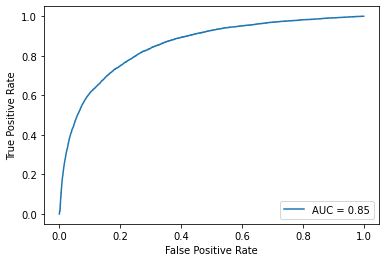

Test


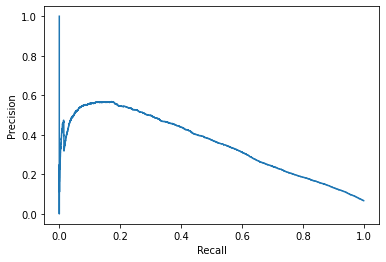

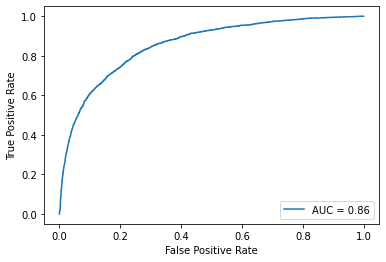

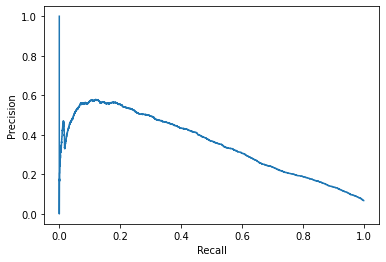

In [22]:
X_train, X_test, y_train, y_test = df_train_test_stratify_split(raw_df, test_size=0.3)

X_train_log_most_v2, _ = log_almost_all_vars_transform_v2(X_train)
X_test_log_most_v2, _ = log_almost_all_vars_transform_v2(X_test)

sm_model_4_train_test = fit_and_eval(StatsModelsLogisticRegression, 
                                     X_train_log_most_v2, X_test_log_most_v2, y_train, y_test)

print("Train")
plot_roc(sm_model_4_train_test, X_train_log_most_v2, y_train)
plot_pr(sm_model_4_train_test, X_train_log_most_v2, y_train)

print("Test")
plot_roc(sm_model_4_train_test, X_test_log_most_v2, y_test)
plot_pr(sm_model_4_train_test, X_test_log_most_v2, y_test)